In [39]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import os
import cv2  
from tqdm import tqdm
from random import shuffle
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization

/Users/xueguoliang/anaconda/envs/tensorflow3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# hyperparameter
IMG_SIZE = 48
LR = 1e-3

def getData(balance_ones=True):
    # images are 48*48 size vectors
    Y_train = []
    X_train = []
    
    Y_test = []
    X_test = []
    
    first = True
   
    #init length of one-hot vector
    n_labels = 7
    
    for line in open('fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            if row[2].strip()=="Training":
                tmp = np.zeros(n_labels)
                tmp[int(row[0])] = 1
                Y_train.append(tmp)
                X_train.append([int(p) for p in row[1].split()])
            elif row[2].strip()=="PublicTest":
                tmp = np.zeros(n_labels)
                tmp[int(row[0])] = 1
                Y_test.append(tmp)
                X_test.append([int(p) for p in row[1].split()])
                            
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    
        
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = getData()

X_train = np.array([i for i in X_train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_train = [i for i in Y_train]

X_test = np.array([i for i in X_test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_test = [i for i in Y_test]

## Training

In [4]:
import tensorflow as tf
tf.reset_default_graph()

In [5]:
# try alexnet
network = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

network = conv_2d(network, 96, 11, strides=4, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 256, 5, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 7, activation='softmax')
network = regression(network, optimizer='momentum',loss='categorical_crossentropy',learning_rate=LR, name='targets')

model = tflearn.DNN(network, tensorboard_dir='alex_bird')

X_train = np.array([i for i in X_train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_train = [i for i in Y_train]

X_test = np.array([i for i in X_test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_test = [i for i in Y_test]

MODEL_NAME = 'affective-bird-{}-{}.model'.format(LR, 'alexnet_15')

model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=15, shuffle=True, batch_size=64,
          validation_set=({'input': X_test}, {'targets': Y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 6734  | total loss: 1.25695 | time: 682.079s
| Momentum | epoch: 015 | loss: 1.25695 - acc: 0.5311 -- iter: 28672/28709
Training Step: 6735  | total loss: 1.25064 | time: 700.362s
| Momentum | epoch: 015 | loss: 1.25064 - acc: 0.5420 | val_loss: 1.42881 - val_acc: 0.4659 -- iter: 28709/28709
--


In [6]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/xueguoliang/myGithub/affectiveComputing/affective-bird-0.001-alexnet_15.model is not in all_model_checkpoint_paths. Manually adding it.


In [9]:
# get all the information in the tensorflow board
# the command line you need to type in in the terminal
#python3 -m tensorflow.tensorboard --logdir=/Users/xueguoliang/myGithub/affectiveComputing/alex_bird

In [32]:
def process_pred_data():
    # convert imgs to array
    dirname = "/Users/xueguoliang/myGithub/affectiveComputing/converted"
    # Load every image file in the provided directory
    filenames = [os.path.join(dirname, fname)
                 for fname in os.listdir(dirname) if fname.split(".")[1] == 'jpg']
    
    # Read every filename as an RGB image
    imgs = [cv2.imread(fname,cv2.IMREAD_GRAYSCALE)for fname in filenames]
    # Then resize the square image to 48 x 48 pixels
    imgs = [cv2.resize(img_i, (48, 48)) for img_i in imgs]
    # Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
    imgs = np.array(imgs).astype(np.float32)    
    np.save('pred_data.npy', imgs)
    
process_pred_data()

In [33]:
pred_data = np.load('pred_data.npy')

## Prediction

In [18]:
MODEL = None

with tf.Graph().as_default():
    network = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

    network = conv_2d(network, 96, 11, strides=4, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 256, 5, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 256, 3, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 7, activation='softmax')
    network = regression(network, optimizer='momentum',loss='categorical_crossentropy',learning_rate=LR, name='targets')

    model = tflearn.DNN(network, tensorboard_dir='alex_bird')
   
    model.load("affective-bird-0.001-alexnet_15.model")
    MODEL = model

In [29]:
def predict(x):
    predict_y = MODEL.predict(x)
    new_y = np.argmax(predict_y, axis=1)
    return new_y.astype(np.uint8)

In [34]:
result = predict(pred_data.reshape(-1,IMG_SIZE,IMG_SIZE,1))

In [49]:
print (result)

[0 3 4 ..., 4 6 4]


In [71]:
sample = []
i=0
while(i<=len(result)):
    sample.append(int(result[i]))
    i = i+50

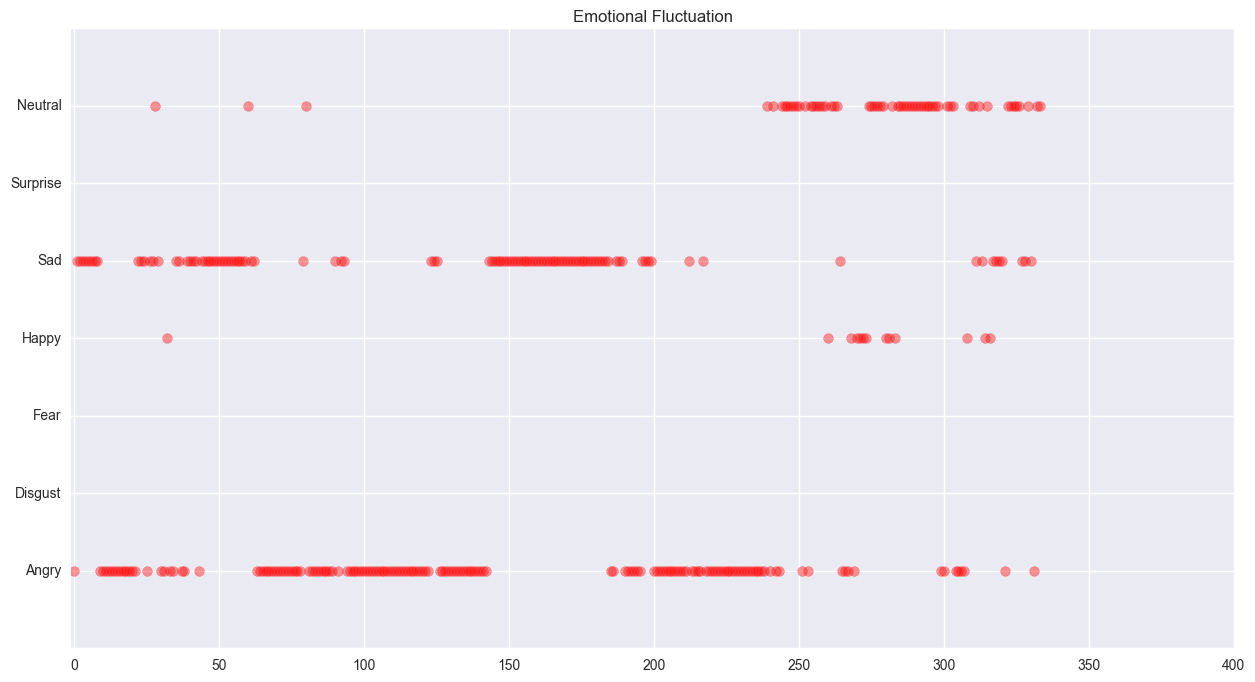

In [99]:
x = range(0,len(sample))
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(x,sample,color="r",s=50,alpha=.4)
ax.set_xlim(-1,400)
ax.set_ylim(-1,7)
ax.set_yticklabels(["","Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])
plt.title("Emotional Fluctuation")
plt.show()

In [75]:
sns.jointplot(x,sample)

TypeError: only integer scalar arrays can be converted to a scalar index

In [41]:
liter = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
final_result = [liter[i] for i in result]

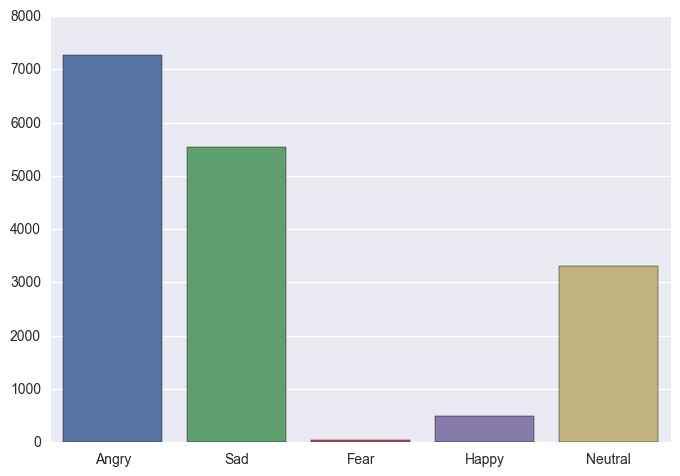

In [40]:
es = []
fs = []
rs = Counter(final_result)
for v in rs:
    es.append(v)
    fs.append(rs[v])

sns.barplot(es, fs)
plt.show()